In [19]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pywt
import numpy as np
import Functions.Strand as strand
from reedsolo import RSCodec

In [20]:
fps = ['CCGCCACGTAATATGTCACT', 'AGAAACCATCCAAGGAACCC']
rps = ['TCACGTATAATCCGACTCTC', 'TTGCAGATGAGTAGCCTTGT']

## 二进制、十进制、ascii码转换函数

In [47]:
def BitToDNA(bitStream:str):
    assert len(bitStream) % 2 == 0
    result = ''
    for i in range(len(bitStream) // 2):
        if bitStream[2*i: (i+1)*2] == '00':
            result += 'A'
        elif bitStream[2*i: (i+1)*2] == '01':
            result += 'C'
        elif bitStream[2*i: (i+1)*2] == '10':
            result += 'G'
        else:
            result += 'T'
    return result

def DecToBin(num:int):
    result = []
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 8):
        result.append("0")
    result.reverse()  
    return "".join(result)

def DecToBin16U(num:int):
    result = []
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 16):
        result.append("0")
    result.reverse()  
    return "".join(result)

def DecToBin16Sign(num:int):
    result = []
    isNegative = False
    if num <0:
        isNegative = True
    if abs(num) > 32767:
        raise ValueError("溢出")
    num = abs(num)
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 15):
        result.append("0")
    if isNegative:
        result.append("1")
    else:
        result.append("0")
    result.reverse()  
    return "".join(result)

def BinToDec16Sign(num:str):
    if num[0] == '1':
        return -int(num[1:], 2)
    else:
        return int(num[1:], 2)
    
def BinToDec(num:str):
    return int(num, 2)

def BinToChr(num:str):
    _ascii = int(num, 2)
    return chr(_ascii)
def ChrToBin(ch:str):
    asc = ord(ch)
    return DecToBin(asc)

def BytesToBit(seq):
    result = ""
    for char in seq:
        result += DecToBin(ord(char))
    return result

def BitToBytes(seq):
    result = ""
    assert len(seq) % 8 == 0
    l = len(seq)
    for i in range(int(l/8)):
        result += BinToChr(seq[i*8: (i+1)*8])
    return result


## 系数矩阵转换成字符串及其反变换

In [48]:
def ArrayToBytes(array):
    # print(array.shape)
    result = ""
    shape = array.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            result += chr(array[i][j])
    return result
def BytesToArray(seq, hei, wid):
    result = np.zeros((hei,wid ))
    assert(len(seq) == wid * hei)
    
    for i in range(hei):
        for j in range(wid):
            result[i][j] = BinToDec(ChrToBin(seq[i*wid + j]))
    
    return np.uint8(result)

## 游程编码

In [49]:
def RunLengthEncode(seq:str):
    # 游程编码  结构化格式，两字节为一组，第一个字节为个数，最大256（0000 0000 表示1） 第二个字节为数据
    result = ""
    seqq = ""
    now = seq[0]
    count = 1
    for i in range(1, len(seq)):
        if now == seq[i]:
            count += 1
            
            if count == 256 and i != len(seq)-1:
                result += DecToBin(count-1) + ChrToBin(now)
                seqq += BinToChr(DecToBin(count-1)) + now
                now = seq[i+1]
                count = 0
                continue
            elif count == 256 and i == len(seq)-1:
                result += DecToBin(count-1) + ChrToBin(seq[i])
                seqq += BinToChr(DecToBin(count-1)) + seq[i]
                break
        else: 
            result += DecToBin(count-1) + ChrToBin(now)
            seqq += BinToChr(DecToBin(count-1)) + now
            now = seq[i]
            count = 1
        if i == len(seq)-1: 
            result += DecToBin(count-1) + ChrToBin(seq[i])
            seqq += BinToChr(DecToBin(count-1)) + seq[i]
    # print("RunLength--原始比特长度：" + str(len(seq) * 8) + "  编码后比特长度：" + str(len(result)) + "  压缩率：" + str((len(seq) * 8 - len(result)) / (len(seq) * 8)))
    return seqq, result

def RunLengthDecode(seq:str):
    # 游程解码
    blocks_count = len(seq) // 16
    result = ""
    for i in range(blocks_count):
        content = seq[16*i : 16*(i+1)]
        #print(content)
        count = BinToDec(content[:8]) + 1
        char = BinToChr(content[8:])
        for j in range(count):
            result += char
    return result

## 哈夫曼编码

In [50]:
# coding:utf-8

#Tree-Node Type
class Node:
    def __init__(self,freq):
        self.left = None
        self.right = None
        self.father = None
        self.freq = freq
    def isLeft(self):
        return self.father.left == self
#create nodes创建叶子节点
def createNodes(freqs):
    return [Node(freq) for freq in freqs]

#create Huffman-Tree创建Huffman树
def createHuffmanTree(nodes):
    queue = nodes[:]
    while len(queue) > 1:
        queue.sort(key=lambda item:item.freq)
        node_left = queue.pop(0)
        node_right = queue.pop(0)
        node_father = Node(node_left.freq + node_right.freq)
        node_father.left = node_left
        node_father.right = node_right
        node_left.father = node_father
        node_right.father = node_father
        queue.append(node_father)
    queue[0].father = None
    return queue[0]
#Huffman编码
def huffmanEncoding(nodes,root):
    codes = [''] * len(nodes)
    for i in range(len(nodes)):
        node_tmp = nodes[i]
        while node_tmp != root:
            if node_tmp.isLeft():
                codes[i] = '0' + codes[i]
            else:
                codes[i] = '1' + codes[i]
            node_tmp = node_tmp.father
    return codes

# 解压缩huffman文件
def decode_huffman(input_string,  char_store, freq_store):
    #input_string 哈夫曼编码
    #char_store 字符集合 
    #freq_store 字符转编码01序列
    encode = ''
    decode = ''
    bitStream = ""
    for index in range(len(input_string)):
        encode = encode + input_string[index]
        for item in zip(char_store, freq_store):
            if encode == item[1]:
                decode = decode + item[0]
                bitStream += ChrToBin(item[0])
                encode = ''
    return decode, bitStream;           

#获取Huffman编码
def getHuffmanCode(string):   
    dict1 ={}
    for  i in string:
        if i in dict1.keys():
            dict1[i] += 1
        else :
            dict1[i] = 1 
    #将字符根据频次排序
    chars_freqs  = sorted(dict1.items(), key = lambda kv:(kv[1], kv[0]))
    #创建huffman节点树
    nodes = createNodes([item[1] for item in chars_freqs])
    root = createHuffmanTree(nodes)
    #每个字符的Huffman编码
    codes = huffmanEncoding(nodes,root)
    #print codes
    dict2 = {}
    for item in zip(chars_freqs,codes):
        #print 'Character:%s freq:%-2d   encoding: %s' % (item[0][0],item[0][1],item[1])
        dict2[item[0][0]] = item[1]
    _str = ''
    for v in string:
        _str += dict2[v]
    # print("Huffman--原始比特长度：" + str(len(string) * 8) + "  编码后比特长度：" + str(len(_str)) + "  压缩率：" + str((len(string) * 8 - len(_str)) / (len(string) * 8)))
    return [_str,dict2]

def encode_huffman(string, huffman_dict):

    _str = ''
    for v in string:
        _str += huffman_dict[v]
    # print("Huffman--原始比特长度：" + str(len(string) * 8) + "  编码后比特长度：" + str(len(_str)) + "  压缩率：" + str((len(string) * 8 - len(_str)) / (len(string) * 8)))
    return [_str,huffman_dict]


# 解码器 Decoder_CoeDataFrame

In [51]:
class Decoder_CoeDataFrame:
    def __init__(self):
        self.coeChannels = None
        self.level = 0
        self.shape = None

        
    def Decode(self, encode_data, huf_dict, isGrayImg=False):
        if huf_dict == None:
            raise ValueError("未提供哈夫曼解码表")
        self.level = (len(encode_data) - 1) // 9
        if isGrayImg:
            self.level = (len(encode_data)-1) // 3
        
        self.Ychannel = [[None for i in range(3)] for _ in range(self.level)]
        self.Ychannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        # print(self.Ychannel)
        
        self.Cbchannel = [[None for i in range(3)] for _ in range(self.level)]
        self.Cbchannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.Crchannel = [[None for i in range(3)] for _ in range(self.level)]
        self.Crchannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.coeChannels = CoeChannels(self.level, isGrayImg)
        for data in encode_data:
            df = CoeDataFrame().CreateDecoder(data, huf_dict)
            # print(df.coe_level, df.coe_where)
            if df.channel_index == 0:  # Y通道
                if df.coe_where == 0:  # LL
                    self.Ychannel[0] = df.coeItem
                else:
                    self.Ychannel[df.coe_level][df.coe_where-1] = df.coeItem
            if not isGrayImg:
                if df.channel_index == 1:  # Cb
                    if df.coe_where == 0:  # LL
                        self.Cbchannel[0] = df.coeItem
                    else:
                        self.Cbchannel[df.coe_level][df.coe_where-1] = df.coeItem
                elif df.channel_index == 2:  # Cb
                    if df.coe_where == 0:  # LL
                        self.Crchannel[0] = df.coeItem
                    else:
                        self.Crchannel[df.coe_level][df.coe_where-1] = df.coeItem
            self.coeChannels.Ychannel = self.Ychannel
            self.coeChannels.Cbchannel = self.Cbchannel
            self.coeChannels.Crchannel = self.Crchannel
        return self
        

# 封装系数帧 CoeDataFrame

In [52]:
# [7bit 描述头 [D6D5 | 00 R 01 G 10 B, D4D3D2 000-111 小波级别, D1D0 00 LL 01 LH 10 HL 11 HH] ] 
# [16bit行数]  [16bit列数] [16bit int16 maxV]  [16bit int16 minV]  [2bit compress method( 01 游程 10 haffman 11 二者兼具)]  [1bit payload bit数是奇数还是偶数]
class CoeDataFrame:
    def __init__(self):
        #               系数元素对象，通道索引， 级数索引， 分量索引
        self.b_desc = ""
        self.b_width = ""
        self.b_height = ""
        self.b_maxV = ""
        self.b_minV = ""
        self.b_ifOdd = ""
        self.b_payload = ""
        self.b_compressMethods = ""
        
        self.coeItem = None
        self.channel_index = None   # 0-Y  1-Cb   2-Cr
        self.coe_level = None   # 小波变换级数
        self.coe_where = None   # 系数位置 0 LL 1 LH 2 HL 3 HH
        self.width = None
        self.height = None
        self.compressMethod = None  # 0 无 1 游程 2 huffman 3 游程＋huffman
        self.is_odd = None  # payload 有效bit数是否为奇数
        
        
        self.huffman_dict = None
    
    def CreateEncoder(self, coeItem, channelIdx, levelIdx, coe_whereIdx, huffman_dict):
        self.coeItem = coeItem
        self.channel_index = channelIdx   # 0-Y  1-Cb   2-Cr
        self.coe_level = levelIdx   # 小波变换级数
        self.coe_where = coe_whereIdx   # 系数位置 0 LL 1 LH 2 HL 3 HH
        self.width = coeItem.quantArray.shape[1]
        self.height = coeItem.quantArray.shape[0]
        self.huffman_dict = huffman_dict
        self.compressMethod = 0  # 0 无 1 游程 2 huffman 3 游程＋huffman
        # 决定采用何种压缩方式
        array_byte = ArrayToBytes(self.coeItem.quantArray)
        ori_len = len(array_byte)
        enc = RunLengthEncode(array_byte)
        enc_bit = enc[1]
        enc_len = len(enc[0])
        
        if ori_len > enc_len:
            # 原始序列长度大于压缩后的序列长度
            self.compressMethod += 1  # 游程
            array_byte = enc[0]
            ori_len = len(array_byte)
            
        # 判断是否采用huffman编码
        enc = encode_huffman(array_byte, self.huffman_dict)
        enc_bit = enc[0]
        enc_len = len(enc[0])
        if ori_len * 8 > enc_len:
            # 如果原始序列长度大于压缩后的序列长度
            self.compressMethod += 2 # 哈夫曼
            
        self.is_odd = False  # payload 有效bit数是否为奇数
        self._encode_data_to_b()
        return self
    
    def CreateDecoder(self, seq, huffman_dict):
        header = seq[:74]
        self.b_desc = header[:7]
        self.b_height = header[7:23]
        self.b_width = header[23:39]
        self.b_maxV = header[39:55]
        self.b_minV = header[55:71]
        self.b_compressMethods = header[71:73]
        self.b_ifOdd = header[73:74]
        self.b_payload = seq[74:]
        self.huffman_dict = huffman_dict
        self._decode_b_to_data()
        return self
        
    def _decode_b_to_data(self):
        self.channel_index = BinToDec(self.b_desc[:2])
        self.coe_level = BinToDec(self.b_desc[2:5])
        self.coe_where = BinToDec(self.b_desc[5:7])
        self.height = BinToDec(self.b_height)
        self.width = BinToDec(self.b_width)
        self.maxV = BinToDec16Sign(self.b_maxV)
        self.minV = BinToDec16Sign(self.b_minV)
        self.compressMethod = BinToDec(self.b_compressMethods)
        is_odd = BinToDec(self.b_ifOdd)
        if is_odd == 1:
            self.is_odd = True
            self.b_payload = self.b_payload[:-1]
            # print("发现有效bit为奇数，已经自动丢弃最后一个bit，有效bit长度：" + str(len(self.b_payload)))
        else:
            self.is_odd = False
        
        if self.compressMethod == 0:
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(BitToBytes(self.b_payload),  self.height, self.width), self.maxV, self.minV)
            # print("不采用任何算法解码")
        elif self.compressMethod == 1:
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(RunLengthDecode(self.b_payload),  self.height, self.width), self.maxV, self.minV)
            # print("采用游程算法解码")
        elif self.compressMethod == 2:
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(decode_huffman(self.b_payload, self.huffman_dict.keys(), self.huffman_dict.values())[0], self.height, self.width), self.maxV, self.minV)
            # print("采用哈夫曼算法解码")
        elif self.compressMethod == 3:
            temp = decode_huffman(self.b_payload, self.huffman_dict.keys(), self.huffman_dict.values())[1]
            self.coeItem = CoefficientItem().decode_quantArray(BytesToArray(RunLengthDecode(temp), self.height, self.width), self.maxV, self.minV)
            # print("采用游程+哈夫曼算法解码")
        
    def _encode_data_to_b(self):
        self.b_desc = DecToBin(self.channel_index)[-2:] + DecToBin(self.coe_level)[-3:] + DecToBin(self.coe_where)[-2:]
        self.b_height = DecToBin16U(self.height)
        self.b_width = DecToBin16U(self.width)
        self.b_maxV = DecToBin16Sign(self.coeItem.maxV)
        self.b_minV = DecToBin16Sign(self.coeItem.minV)
        self.b_compressMethods = DecToBin(self.compressMethod)[-2:]
        
        if self.compressMethod == 0:
            self.b_payload = BytesToBit(ArrayToBytes(self.coeItem.quantArray))
            # print("不采用任何压缩编码")
        elif self.compressMethod == 1:
            self.b_payload = BytesToBit(RunLengthEncode(ArrayToBytes(self.coeItem.quantArray))[1])
            # print("采用游程压缩编码")
        elif self.compressMethod == 2:
            self.b_payload = encode_huffman(ArrayToBytes(self.coeItem.quantArray), self.huffman_dict)[0]
            # print("采用哈夫曼压缩编码")
        elif self.compressMethod == 3:
            temp = RunLengthEncode(ArrayToBytes(self.coeItem.quantArray))[0]
            self.b_payload = encode_huffman(temp, self.huffman_dict)[0]
            # print("采用游程+哈夫曼压缩编码")
        if len(self.b_payload) % 2 == 1:
            self.b_ifOdd = "1"
            self.b_payload += "0"
            # print("发现有效bit为奇数，已经自动在最后一个bit后补0，总长度："+ str(len(self.b_payload)))
        else:
            self.b_ifOdd = "0"
        
    def get_data_stream(self):
        return self.b_desc + self.b_height + self.b_width + self.b_maxV + self.b_minV + self.b_compressMethods + self.b_ifOdd + self.b_payload
        
        

# 封装DNA序列帧 DNAFrameGroup

In [109]:
# 针对每一个CoeDataFrame的一组DNAFrame

class DNAFrameGroup:
    def __init__(self):
        self.rFV = ''  # 特征向量下游引物
        self.bp_payload = ''
        self.fp1 = ''
        self.rp1 = ''
        self.fp2 = ''
        self.rp2 = ''
        self.coeDataFrame = None
        self.final_payload_length = 0  # 最后一帧DNAFrame有效载荷长度
        self.DNAFrame_count = 0  # 对于一帧CoeDataFrame所包含的DNAFrame数量
        self.isPreview = False
        self.vectorSeq = ""
        self.max_payload_length = 326
        self.dna_seq_group = []  # 对于一帧CoeDataFrame所包含的全部DNA序列
        self.RSCodeCount = 4
        self.last_encoder_address_count = 0
        
        
    def CreateEncoder(self, bit_stream: str, fp1, fp2, rp2, rp1, isPreview, vectorSeq="", RSCodeCount = 4):
        #                    字节流             两层上下游引物       文件索引     是否是摘要序列   特征向量    RS码字节数             上一个编码器地址计数
        self.fp1 = fp1
        self.fp2 = fp2
        self.rp1 = rp1
        self.rp2 = rp2
        self.isPreview = isPreview
        self.vectorSeq = vectorSeq
        self.RSCodeCount = RSCodeCount
        self.dna_seq_group = []
        if isPreview:
            self.max_payload_length = 112 - 4 * RSCodeCount
        else:
            self.max_payload_length = 160 - 4 * RSCodeCount 
        
        segment_count = len(bit_stream) // 2 // self.max_payload_length
        print("需要分割的段数为：", segment_count+1)
        if segment_count+1 > 4096:
            raise IndexError("分割段数超过4096，无法在6个碱基的地址码下完成分割")
        bit_seqs = []
        dna_seqs = []
        # 将原始bit流分割成不同的段数后添加到列表中
        for i in range(segment_count):
            bit_seqs.append(bit_stream[i*self.max_payload_length*2 : (i+1)*self.max_payload_length*2])
        bit_seqs.append(bit_stream[segment_count * self.max_payload_length * 2:])
        # 纠错码添加
        
        #  为了生成原始序列而暂时添加的
        if len(bit_stream) % 2 != 0:
            bit_stream += "0"
        
        for i in range(len(bit_seqs)):
            #编码
            if len(bit_seqs[-1]) % 8 != 0:
                bit_seqs[-1] += '0' * (8 - len(bit_seqs[-1]) % 8)
            ecc=RSCodec(4)#纠错码字长度，可纠正n/2个误读
            
            bit_header = DecToBin(self.last_encoder_address_count + i)
            if len(bit_header) < 12:
                bit_header = '0' * (12 - len(bit_header)) + bit_header
            # print("self.last_encoder_address_count + i", self.last_encoder_address_count + i)
            #print(bit_header)
            #print("原始比特长度", len(bit_seqs[i]))
            # print("原始比特流", BytesToBit(BitToBytes(bit_seqs[i])))
            byte_msg=ecc.encode(b''.join(ord(ch).to_bytes(1, byteorder='little', signed=False) for ch in BitToBytes(bit_seqs[i])))
            #转换为二进制
            #print('加纠错码后比特长度：', len(byte_msg)*8)
            binary_code=''.join(format(x,'08b') for x in byte_msg)
            #print('加纠错码后比特流', binary_code)
            prepare_seq = bit_header + binary_code

            bp_header_payload = BitToDNA(prepare_seq)
            
            fpl = []
            rpl = []
            
            fpl.append(self.fp1)
            if self.isPreview:
                # 如果是预览文件序列
                fpl.append(self.vectorSeq)
            fpl.append(self.fp2)
            rpl.append(self.rp2)
            rpl.append(self.rp1)
            #if self.isPreview:
                #rpl.append(self.rFV)
            bp_this_seq = strand.assemble_primer_and_payload(fpl, bp_header_payload, rpl)
            #print(bp_this_seq[0])
            # print('[', i+1, ']', '序列碱基数', bp_this_seq[0].__len__())
            self.dna_seq_group.append(bp_this_seq[0])
            
            #纠错
            #先转换为bytearray形式
            bytes_msg=bytes(int(binary_code[j:j+8],2) for j in range(0,len(binary_code),8))
            array_msg=bytearray(bytes_msg)
            #再纠错
            data=ecc.decode(array_msg)
            msg=data[0]
            result = ''.join(DecToBin(num) for num in msg)
            assert bit_seqs[i] == result
            
        self.last_encoder_address_count += segment_count + 1
        return self

# [TODO]  DNA序列帧解码器 Decoder_DNAFrame  

In [54]:
class Decoder_DNAFrame:
    def __init__(self):
        self.bp_seq = ''

# 小波系数管理类、图像类

In [55]:
# 小波系数管理类
class CoeChannels:
    def __init__(self, level, isGrayImg=False):
        self.level = level 
        
        self.Ychannel = [[] for _ in range(level)]
        self.Ychannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.Cbchannel = [[] for _ in range(level)]
        self.Cbchannel.insert(0, None)
        
        self.Crchannel = [[] for _ in range(level)]
        self.Crchannel.insert(0, None)
        
        self.yIDWT = [[], ()]
        self.cbIDWT = [[], ()]
        self.crIDWT = [[], ()]
        
        self.huf_dict = None   # 哈夫曼编码表，需要在使用Decode_DNAImage时传递此解码表
        self.isGrayImg = isGrayImg
        
    def SetYchannel(self, coes):
        
        self.Ychannel = [[] for _ in range(self.level)]
        self.Ychannel.insert(0, None) 
        
        self.Ychannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Ychannel[i+1].append(coeItem)
                # print("Y:", coes[i+1][j].shape)
                
    def SetCbchannel(self, coes):
        
        self.Cbchannel = [[] for _ in range(self.level)]
        self.Cbchannel.insert(0, None) 
        
        self.Cbchannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Cbchannel[i+1].append(coeItem)
                # print("Cb:", coes[i+1][j].shape)
                
    def SetCrchannel(self, coes):
        
        self.Crchannel = [[] for _ in range(self.level)]
        self.Crchannel.insert(0, None) 
        
        self.Crchannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Crchannel[i+1].append(coeItem)
                # print("Cr:", coes[i+1][j].shape)
                
    def AssembleAllChannelsForIDWT(self):
        # 重新组合全部通道的系数，为了进行离散小波逆变换
        if self.level != 1:
            raise ValueError("此函数仅支持组合级数为1的小波变换系数")
        self.yIDWT = [self.Ychannel[0].IquantArray, (self.Ychannel[1][0].IquantArray,
                                                    self.Ychannel[1][1].IquantArray,
                                                    self.Ychannel[1][2].IquantArray,)]
        
        self.cbIDWT = [self.Cbchannel[0].IquantArray, (self.Cbchannel[1][0].IquantArray,
                                                    self.Cbchannel[1][1].IquantArray,
                                                    self.Cbchannel[1][2].IquantArray,)]
        
        self.crIDWT = [self.Crchannel[0].IquantArray, (self.Crchannel[1][0].IquantArray,
                                                    self.Crchannel[1][1].IquantArray,
                                                    self.Crchannel[1][2].IquantArray,)]
        
        return self
    
    # 将小波系数按照最大最小值除以缩放因子将对应范围内的小波系数变为0
    def ConstraintCoeItemsToZero(self, factor):
        
        if factor == 0:
            self.RecaculateAllItems()
            return
        for i in range(self.level):
            for j in range(3):
                ff = 1
                if j == 2:
                    ff = 2
                t = self.Ychannel[i+1][j].originalArray
                a = t < t.max() / (factor // (i + 1) // ff + 1)
                b = t > t.min() / (factor // (i + 1) // ff + 1)
                t[a & b] = 0
                self.Ychannel[i+1][j].originalArray = t
                
                if self.isGrayImg:
                    self.RecaculateAllItems()
                    return
                t = self.Cbchannel[i+1][j].originalArray
                a = t < t.max() / (factor // (i + 1) // ff + 1)
                b = t > t.min() / (factor // (i + 1) // ff + 1)
                t[a & b] = 0
                self.Cbchannel[i+1][j].originalArray = t
                t = self.Crchannel[i+1][j].originalArray
                a = t < t.max() / (factor // (i + 1) // ff + 1)
                b = t > t.min() / (factor // (i + 1) // ff + 1)
                t[a & b] = 0
                self.Crchannel[i+1][j].originalArray = t
                
        self.RecaculateAllItems()
    
    def RecaculateAllItems(self):
        if self.isGrayImg:
            self.Ychannel[0].RecalculateAllArray()
            for i in range(self.level):
                for j in range(3):
                    self.Ychannel[i+1][j].RecalculateAllArray()
                    return
            
        self.Ychannel[0].RecalculateAllArray()
        self.Cbchannel[0].RecalculateAllArray()
        self.Crchannel[0].RecalculateAllArray()
        for i in range(self.level):
            for j in range(3):
                self.Ychannel[i+1][j].RecalculateAllArray()
                self.Cbchannel[i+1][j].RecalculateAllArray()
                self.Crchannel[i+1][j].RecalculateAllArray()
    
    def AssembleAndCalulateIDWT_2levels(self, bias):
        result = []
        if not self.isGrayImg:
            
            pic = np.dstack((self.Ychannel[0].IquantArray, 
                     self.Cbchannel[0].IquantArray, 
                     self.Crchannel[0].IquantArray )) + bias

            temp = pic / pic.max() * 255
            temp[temp > 255] = 255
            pic = np.uint8(temp)
            img0 = Image.fromarray(pic, mode="RGB").convert("RGB")
            result.append(img0)

            iy = self.Ychannel[0].IquantArray
            ib = self.Cbchannel[0].IquantArray
            ir = self.Crchannel[0].IquantArray

            for i in range(self.level):

                self.yIDWT = [iy, (self.Ychannel[i+1][0].IquantArray,
                                                            self.Ychannel[i+1][1].IquantArray,
                                                            self.Ychannel[i+1][2].IquantArray,)]

                self.cbIDWT = [ib, (self.Cbchannel[i+1][0].IquantArray,
                                                            self.Cbchannel[i+1][1].IquantArray,
                                                            self.Cbchannel[i+1][2].IquantArray,)]

                self.crIDWT = [ir, (self.Crchannel[i+1][0].IquantArray,
                                                            self.Crchannel[i+1][1].IquantArray,
                                                            self.Crchannel[i+1][2].IquantArray,)]
                iy = pywt.waverec2(self.yIDWT, "db1", mode="periodization")
                ib = pywt.waverec2(self.cbIDWT, "db1", mode="periodization")
                ir = pywt.waverec2(self.crIDWT, "db1", mode="periodization")

                # print(iy.min(), ib.min(), ir.min())
                # print(iy.max(), ib.max(), ir.max())

                pic = np.dstack(((iy), (ib), (ir))) + bias * (self.level - i)

                temp = pic / pic.max() * 255
                temp[temp > 255] = 255
                pic = np.uint8(temp)

                # pic = np.dstack(((iy), (ib), (ir))) + bias
                # pic = np.uint8(pic)

                img1 = Image.fromarray(pic, mode="RGB").convert("RGB")

                result.append(img1)
        
        else:
            pic = self.Ychannel[0].IquantArray + bias

            temp = pic / pic.max() * 255
            temp[temp > 255] = 255
            pic = np.uint8(temp)
            img0 = Image.fromarray(pic, mode="L")
            result.append(img0)

            iy = self.Ychannel[0].IquantArray

            for i in range(self.level):

                self.yIDWT = [iy, (self.Ychannel[i+1][0].IquantArray,
                                                            self.Ychannel[i+1][1].IquantArray,
                                                            self.Ychannel[i+1][2].IquantArray,)]

                iy = pywt.waverec2(self.yIDWT, "db1", mode="periodization")

                pic = iy + bias * (self.level - i)

                temp = pic / pic.max() * 255
                temp[temp > 255] = 255
                pic = np.uint8(temp)

                img1 = Image.fromarray(pic, mode="L")

                result.append(img1)
   
        return result

    def encode(self, level=0, factor=0):
        #             进行编码的小波级数  缩放因子
        if level == 0:
            level = self.level
        result = []
        haf_data = ""
        self.ConstraintCoeItemsToZero(factor)
        # 先对高频分量进行游程编码后作为哈夫曼编码的原始语料
        haf_data += ArrayToBytes(self.Ychannel[0].quantArray)
        if not self.isGrayImg:
            haf_data += ArrayToBytes(self.Cbchannel[0].quantArray)
            haf_data += ArrayToBytes(self.Crchannel[0].quantArray)
        for i in range(level):
            for j in range(3):
                array = ArrayToBytes(self.Ychannel[i+1][j].quantArray)
                data = array
                ori_len = len(array) * 8
                enc_data = RunLengthEncode(array)[0]
                if ori_len > len(enc_data):
                    data = enc_data
                haf_data += data
                
                if not self.isGrayImg:
                    array = ArrayToBytes(self.Cbchannel[i+1][j].quantArray)
                    data = array
                    ori_len = len(array) * 8
                    enc_data = RunLengthEncode(array)[0]
                    if ori_len > len(enc_data):
                        data = enc_data
                    haf_data += data

                    array = ArrayToBytes(self.Crchannel[i+1][j].quantArray)
                    data = array
                    ori_len = len(array) * 8
                    enc_data = RunLengthEncode(array)[0]
                    if ori_len > len(enc_data):
                        data = enc_data
                    haf_data += data
                
        huf_dict = getHuffmanCode(haf_data)[1]
        
        result.append(
            CoeDataFrame().CreateEncoder(self.Ychannel[0], 0, 0, 0, huf_dict).get_data_stream()
        )
        if not self.isGrayImg:
            result.append(
                CoeDataFrame().CreateEncoder(self.Cbchannel[0], 1, 0, 0, huf_dict).get_data_stream()
            )
            result.append(
                CoeDataFrame().CreateEncoder(self.Crchannel[0], 2, 0, 0, huf_dict).get_data_stream()
            )
        for i in range(level):
            for j in range(3):
                result.append(
                    CoeDataFrame().CreateEncoder(self.Ychannel[i+1][j], 0, i+1, j+1, huf_dict).get_data_stream()
                )
                if not self.isGrayImg:
                    result.append(
                        CoeDataFrame().CreateEncoder(self.Cbchannel[i+1][j], 1, i+1, j+1, huf_dict).get_data_stream()
                    )
                    result.append(
                        CoeDataFrame().CreateEncoder(self.Crchannel[i+1][j], 2, i+1, j+1, huf_dict).get_data_stream()
                    )
        self.huf_dict = huf_dict
        
        ori_cost = self.Ychannel[level][2].quantArray.shape[0] * self.Ychannel[level][2].quantArray.shape[1] * 12 * 2
        now_len = 0
        # for i in range(len(result)):
        #     now_len += len(result[i])
        #     print(len(result[i]))
        # now_cost = now_len / 4
        # print("----------------")
        # print("原始成本：{}元".format(ori_cost))
        # print("压缩后成本：{}元".format(now_cost))
        # print("成本压缩率：{}%".format((ori_cost - now_cost) / ori_cost*100))
        # print("----------------")
        return result

# 小波系数类
class CoefficientItem:
    def __init__(self, originalArray=np.ones((2, 2))):
        self.maxV = 0
        self.minV = 0
        self.delta = 0
        self.originalArray = None
        self.quantArray = None
        self.IquantArray = None
        
        self.originalArray = originalArray
        self.maxV = int(originalArray.max())
        self.minV = int(originalArray.min())
        self.delta = (self.maxV - self.minV) / 255
        t = (self.originalArray - self.minV) / self.delta
        t[t > 255] = 255
        self.quantArray = np.uint8(t)
        self.IquantArray = self.quantArray * self.delta + 1*self.minV
        
    def decode_quantArray(self, quantArray, maxV, minV):
        self.quantArray = quantArray
        self.maxV = maxV
        self.minV = minV
        self.delta = (self.maxV - self.minV) / 255
        self.IquantArray = self.quantArray * self.delta + self.minV
        return self
        
    def RecalculateIquantArray(self):
        self.IquantArray = self.quantArray * self.delta + self.minV
        
    def RecalculateAllArray(self):
        self.maxV = int(self.originalArray.max())
        self.minV = int(self.originalArray.min())
        self.delta = (self.maxV - self.minV) / 255
        
        t = (self.originalArray - self.minV) / self.delta
        t[t > 255] = 255
        self.quantArray = np.uint8(t)
        self.IquantArray = self.quantArray * self.delta + self.minV

In [56]:
# 图像类
class DNAImage:
    def __init__(self, image:Image):
        self.image = image
        self.level = 0
        self.shape = None
        self.RGB_array = None          # RGB通道图像矩阵 维度（x, y, 3)
        self.RGB_img = None
        self.YCbCr_array = None
        self.YCbCr_img = None
        
        self.coeChannels = None # 存储小波变换系数的三通道列表 【Y， Cb， Cr】

        self.info_init()
        
    def info_init(self):
        self.RGB_img = self.image.convert("YCbCr")#.resize((96, 54))
        self.YCbCr_img = self.image.convert("RGB")#.resize((16*20, 9*20))
        self.gray_img = self.image.convert("L").resize((55, 36))
        self.RGB_array = np.array(self.RGB_img)
        self.YCbCr_array = np.array(self.YCbCr_img)
        self.gray_array = np.array(self.gray_img)
        
        # DC平移
        self.YCbCr_array = np.int16(self.YCbCr_array)
        #self.YCbCr_array -= 128

        
        print(self.YCbCr_array.shape)
        return self
        
    def DWT(self, level, isGrayImg=False):
        self.level = level
        
        if not isGrayImg:
            self.coeChannels = CoeChannels(level)
            Yc = pywt.wavedec2(self.YCbCr_array[:,:,0], 'db1', mode="periodization", level=level)
            Cbc = pywt.wavedec2(self.YCbCr_array[:,:,1], 'db1', mode="periodization", level=level)
            Crc = pywt.wavedec2(self.YCbCr_array[:,:,2], 'db1', mode="periodization", level=level)

            self.coeChannels.SetYchannel(Yc)
            self.coeChannels.SetCbchannel(Cbc)
            self.coeChannels.SetCrchannel(Crc)
        else:
            self.coeChannels = CoeChannels(level, True)
            self.coeChannels.SetYchannel(pywt.wavedec2(self.gray_array, 'db1', mode="periodization", level=level))
        
        
        return self
    
    def show(self):
        plt.imshow(self.RGB_array/255)

# 二进制阶段全流程演示，包括读取图像 设置小波变换级数 编码小波级数 缩放因子设置 图像预览 成本显示

(679, 1049, 3)


/home/zsf/lib/python3.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in true_divide


<Figure size 2880x1440 with 0 Axes>

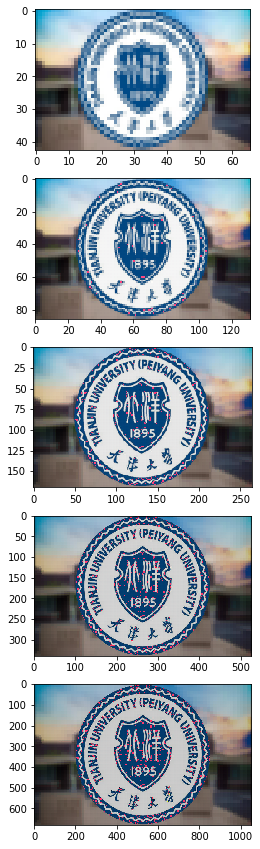

In [73]:
dna = DNAImage(Image.open("../resnet/FINAL_EXP_IMAGES/tju_1.png"))
t = dna.DWT(4, isGrayImg=False)

enc = t.coeChannels.encode(4, factor=15)
imgs = Decoder_CoeDataFrame().Decode(enc, dna.coeChannels.huf_dict, isGrayImg=False).coeChannels.AssembleAndCalulateIDWT_2levels(0)
plt.figure(figsize=(40,20)) 
f, ax = plt.subplots(len(imgs), 1, figsize=(40, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i], cmap='gray', interpolation='nearest')
    

# 生成摘要文件及原始文件DNA序列，显示最终成本

In [74]:
total_bp = 0
total_seq_num_preview = 0
total_seq_num_other = 0
el = DNAFrameGroup()
eh = DNAFrameGroup()
DNAFrameGroup_L = []
DNAFrameGroup_H = []
for bitStream in enc[:3]:  # 编码摘要文件（低频分量）三通道序列

    el = el.CreateEncoder(bitStream, fps[0], fps[0]+fps[0], '', rps[0], True, 'AAAAATTTTTGGGGGCCCCCTTTTTAAAAA')
    DNAFrameGroup_L.append(el)
    total_seq_num_preview += len(el.dna_seq_group)
    for c in el.dna_seq_group:
        total_bp += len(c)
for bitStream in enc[3:]:  # 编码原始文件（高频分量）三通道序列

    eh = eh.CreateEncoder(bitStream, fps[0], fps[0], '', rps[0], False, 'AAAAATTTTTGGGGGCCCCCTTTTTAAAAA')
    DNAFrameGroup_H.append(eh)
    total_seq_num_other += len(eh.dna_seq_group)
    for c in eh.dna_seq_group:
        total_bp += len(c)
print("********************[最终成本结算]********************")
print("DNA条数总计：", total_seq_num_preview + total_seq_num_other, "条")
print("[摘要文件]条数总计：", total_seq_num_preview, "条")
print("[摘要文件]预估不分析测序费用（测序深度100x计算PE250）：", total_seq_num_preview * 100 / 250, "元")
print("PE250测序 不足200元按照200元计费")
print("[原始文件(包括摘要文件)]条数总计：", total_seq_num_preview + total_seq_num_other, "条")
print("[原始文件(包括摘要文件)]预估不分析测序费用（测序深度100x计算PE250）：", (total_seq_num_preview + total_seq_num_other) * 100 / 250, "元")
print("PE250测序 不足200元按照200元计费")
print("总测序费用（一次摘要一次原始访问）：", total_seq_num_preview * 100 / 250 + (total_seq_num_preview + total_seq_num_other) * 100 / 250, '元', "!!不足400按400计算")

需要分割的段数为： 119
需要分割的段数为： 119
需要分割的段数为： 119
需要分割的段数为： 51
需要分割的段数为： 52
需要分割的段数为： 56
需要分割的段数为： 50
需要分割的段数为： 51
需要分割的段数为： 51
需要分割的段数为： 40
需要分割的段数为： 39
需要分割的段数为： 36
需要分割的段数为： 108
需要分割的段数为： 95
需要分割的段数为： 97
需要分割的段数为： 119
需要分割的段数为： 108
需要分割的段数为： 112
需要分割的段数为： 78
需要分割的段数为： 75
需要分割的段数为： 77
需要分割的段数为： 214
需要分割的段数为： 198
需要分割的段数为： 196
需要分割的段数为： 259
需要分割的段数为： 247
需要分割的段数为： 254
需要分割的段数为： 133
需要分割的段数为： 122
需要分割的段数为： 125
需要分割的段数为： 429
需要分割的段数为： 421
需要分割的段数为： 413


AssertionError: 

In [1818]:
for e in DNAFrameGroup_L:
    strand.check_max_2seqs_complement_hybird(fps[0],strand.get_complement_strand(e.dna_seq_group[0])[:-100] )


  CCGCCACGTAATATGTCACT
      | ||| || |||   |
ATACTTGCGCACTAAACAAACAACGAAATAAACAAACAAAGCTATTCGGAGTCAAACAAACAAACAAACAAACAAACAAACAAACAAACCTATTCACGATAGACCTACTTGTAGTTTTGTAGCTCCTGAGCTATAGCAAGCAAAGAAACAAACACCCTGCTGGGTGTATGTGGGCACGAGAGTACGACCGGCTTACTGGCGTGCTCGGGAAACAAACAAACGAAGTCGCGCTTTCCGTCAATTGGTTTATTTGTTTTTGATTAACTCCCGCATTCCAAAATAAACAAGGTGATGAGCTTGCTTTTGGGAGCAAACCATTATGTTCCGATGAGTAGACGTTCTCTCAGCCTAATATGCACTGGAGCCCTGTCCCAGTCATT
  CCGCCACGTAATATGTCACT
      | ||| || |||   |
ATACTTGCGCACTAAACAAACAACGAAATAAACAAACAAAGCTATTCGGAGTCAAACAAACAAACAAACAAACAAACAAACAAACAAACCTATTCACGATAGACCTACTTGTAGTTTTGTAGCTCCTGAGCTATAGCAAGCAAAGAAACAAACACCCTGCTGGGTGTATGTGGGCACGAGAGTACGACCGGCTTACTGGCGTGCTCGGGAAACAAACAAACGAAGTCGCGCTTTCCGTCAATTGGTTTATTTGTTTTTGATTAACTCCCGCATTCCAAAATAAACAAGGTGATGAGCTTGCTTTTGGGAGCAAACCATTATGTTCCGATGAGTAGACGTTCTCTCAGCCTAATATGCACTGGAGCCCTGTCCCAGTCATT
  CCGCCACGTAATATGTCACT
      | ||| || |||   |
ATACTTGCGCACTAAACAAACAACGAAATAAACAAACAAAGCTATTCGGAGTCAAACAAACAAACAAACAAACAAACAAACAAACAAACCTATTCACGAT

In [2]:
with open("FinalPrimer.txt", 'r') as f:
    primers = eval(f.read())
print(primers.__len__())

884


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

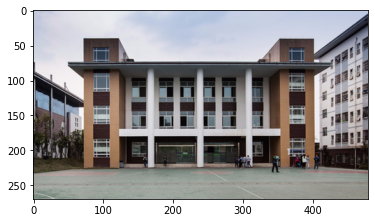

In [46]:
img = Image.open("./FinalImages/c.jpg")
out = img.resize((480, 270), Image.ANTIALIAS)
plt.imshow(out)
out.save("./FinalImages/3.png", "png")

# 最终合成

In [1]:
vector_dict = {'haihe_13': 'GGTGCCCCGTGCTTTAGACTTTATCCTCAC',
 'animal_2': 'AATGCGGCGTGCTGTACACTATACTCTGAC',
 'haihe_11': 'CGTTCCCCGAGCTTTAAACTATATCATCAC',
 'haihe_1': 'CGTGCTTGGAGCTTTGCACTATCTTATCAC',
 'haihe_15': 'CGTGCCCCGAGCTTTAAACTTTATCCTCAC',
 'animal_3': 'AATCGGGCGTGCTGTACACTATGCTCTGAC',
 'haihe_14': 'CGTGCCCCGTGCTTTAGACTATATCCTCAC',
 'animal_7': 'CGTCATGCAAGCATGAGACTCTATTGTCAC',
 'tju_5': 'CGTGCCCCGTGCTTTAAACTATATCCTCAC',
 'tju_10': 'GGTGCCCCGTGCTTTAGACTATATCCTCAC',
 'tju_3': 'CGTTCCCCGAGCTTTAAACTATCTCATCAA',
 'flower_6': 'CGTTCCCCGTGCTTAAAACCATATCCTCAC',
 'haihe_10': 'CGTTCCCCGAGCTTTACACTATATCATCAC',
 'grandpa': 'AATGGGGCGTGCGCAAGACCGCATCCTTTA',
 'animal_12': 'CGTGCCCCGTGCTTAAGACTATATCCTCAC',
 'animal_16': 'GGTGTCACGAGCATATAACTGTATGTTCAG',
 'flower_9': 'CGTTCCCGGAGCTTTAAACTATATTCTCAC',
 'tju_8': 'CGTTCCCCGAGCTTTAAATTATATCATCAC',
 'flower_1': 'GGTGCTCCGTGCTGTAAACTTTATCCTCAC',
 'tju_6': 'CGTGCTCCGAGCTTTACACTATATCATCAC',
 'animal_4': 'AATGCTTCGTGCTGTACACTATACTCTGAC',
 'animal_8': 'AATGCATCGTGCTGTACAGTATACTCTGAC',
 'flower_14': 'CGTTTCCCGAGCTTTAAACTTTATCCTCAC',
 'tju_1': 'TGTGCTTCGAGCTTCTCACTATATCCTCAA',
 'flower_13': 'CGTTTCCGGAGCTTAAAACCATATGCTCAC',
 'animal_15': 'CGTGTCACGAGCTTATAACTGTATGTTCAG',
 'haihe_7': 'CGTTCCCGGAGCTTTAAACTATCTTATCAA',
 'flower_2': 'GGTGCAGCGTGCTTTAAACTTTATCCTCAC',
 'tju_9': 'CGTGCCCCGTGCTTAAAACTATATCCTCAA',
 'flower_7': 'CGTTCCCCGAGCTTAAAACTTTATCCTCAC',
 'haihe_5': 'CGTTCCCGAAGCTTTAAACGATCTCATCAC',
 'tju_11': 'CGTTCCCCGAGCTTAAAACTTTATCCTCAC',
 'flower_3': 'GATGCTTCGTGCTTTAAACTTTATCCTCAC',
 'haihe_4': 'CGTTCCCCGAGCTTTAAACTATATCCTCAC',
 'haihe_6': 'CGTTCCCGGAGCTTTTAATTATCTTATCAA',
 'animal_13': 'CGTGCCCCGAGCTTTAGACTATATCCTCAC',
 'tju_16': 'GGTGCCCCGTGCTTTAAACTTTATCCTCAC',
 'haihe_12': 'CGTGCCCCGTGCTTTACACTATATCCTCAC',
 'animal_10': 'CGTGCCCCGTGCTTAAAACTATATCCTCAC',
 'tju_7': 'CGTTCCTCGAGCTTTTAATTATATCATCAA',
 'flower_8': 'CGTTCCCGGAGCTTAAAACTATATCCTCAC',
 'haihe_16': 'CGTGCCCCGAGCTTTACATTATATCATCAC',
 'tju_2': 'CGTGCCTCGAGCTTTTCACTATATCATCAA',
 'tju_4': 'CGTGCCCCGTGCTTTAGACTATATCCTCAA',
 'animal_6': 'CGTCATGCGAGCTTGAGACTCTATTGTCAC',
 'tju_13': 'GGTGCCCCGTGCTTTAGACTATATCCTCAC',
 'flower_16': 'GATTCTTCATGCGTTACACTGTATCTTCAC',
 'tju_15': 'GGTGCCCCGTGCTTTAGACTATATCCTCAA',
 'tju_14': 'GGTTCCCCGTGCTTTAAACAATATCCTCAA',
 'animal_11': 'CGTGCGCCGTGCTTAAGACTATATCCTCAC',
 'haihe_3': 'CGTGCCTCGAGCTTTACATTATATCCTCAC',
 'tju_12': 'GGTGCAACGTGCTTTAAACTTTATCCTCAC',
 'haihe_9': 'CGTGCCCCGAGCTTTAAATTATATCATCAC',
 'animal_1': 'CGTGATGCGAGCTTGAGACTCTATTGTCAC',
 'flower_10': 'CGTTCCTCGAGCTTTTAATTATATCCTCAA',
 'flower_15': 'CGTTTCCCGAGCTTATAACTTTATCCTCAC',
 'flower_4': 'CGTTCCCCGAGCTTAAAACTTTATCCTCAC',
 'animal_5': 'GGTGCCCCGTGCTTAAGACTATATCCTCAC',
 'animal_14': 'CGTGCCCCGTGCTTAAAACTTTATCCTCAC',
 'animal_9': 'CGTGATAAGAGCTTGAGACTCTATTGTCAC',
 'flower_5': 'CGCTCCCGGAGCTTAAAACTATATCCTCAC',
 'haihe_2': 'CGTTCTTGGAGCTTTACATTATCTTATCAA',
 'flower_12': 'CGTGCCTCGAGCTTTTCATTTTATCCTCAC',
 'flower_11': 'CGTTCCCGGAGTTTCTAACCATATTCTCAA',
 'haihe_8': 'CGTGCTTCGAGCTTTACACTATATCATCAC'}

In [147]:
with open("../resnet/3_constraint_primer_pool.txt", 'r') as f:
    pl = eval(f.read())
    print(len(pl))
CORE_UFP = pl[0]
ADDITIONAL_UFP = pl[1]
URP = pl[2]
FPS = pl[3:68]
LAYER_FPS = pl[68:68+17]

90


In [148]:
need_original = ["tju_1", "tju_12", "tju_13", "tju_16", "flower_3", "haihe_2", "animal_1", "animal_12"]
root = "../resnet/FINAL_EXP_IMAGES/"
#files = os.listdir(root)
files = ["tju_"+str(i+1)+".png" for i in range(16)] + ["haihe_"+str(i+1)+".png" for i in range(16)] + ["flower_"+str(i+1)+".png" for i in range(16)] + ["animal_"+str(i+1)+".png" for i in range(16)] + ["grandpa.jpg"]
FINAL_SEQ = {}

for file in files:
    FINAL_SEQ[file.split(".")[0]] = {"core":[], "additional":[]}

    dna = DNAImage(Image.open(root+file))
    t = dna.DWT(4, isGrayImg=False)
    enc = t.coeChannels.encode(4, factor=6)

    total_seq_num_preview = 0
    total_seq_num_other = 0
    el = DNAFrameGroup()
    eh = DNAFrameGroup()
    DNAFrameGroup_L = []
    DNAFrameGroup_H = []
    for bitStream in enc[:3]:  # 编码摘要文件（低频分量）三通道序列
        
        el = el.CreateEncoder(bitStream, CORE_UFP,  LAYER_FPS[files.index(file)//4]+FPS[files.index(file)] , '', URP, True, vector_dict[file.split(".")[0]])
        DNAFrameGroup_L.append(el)
        total_seq_num_preview += len(el.dna_seq_group)
        for c in el.dna_seq_group:
            if len(c) != 228:
                c = c[:90] + c[90:-20] + c[90:-20]*((118-len(c[90:-20]))//len(c[90:-20])) + c[90:90+(118-len(c[90:-20]))%len(c[90:-20])] +c[-20:]
                print("                        ", len(c))
            FINAL_SEQ[file.split(".")[0]]["core"].append(c)
    if file.split(".")[0] in need_original:
        for bitStream in enc[3:]:  # 编码原始文件（高频分量）三通道序列

            eh = eh.CreateEncoder(bitStream, ADDITIONAL_UFP, FPS[files.index(file)], '', URP, False, vector_dict[file.split(".")[0]])
            DNAFrameGroup_H.append(eh)
            total_seq_num_other += len(eh.dna_seq_group)
            for c in eh.dna_seq_group:
                if len(c) != 226:
                    c = c[:40] + c[40:-20] + c[40:-20]*((166-len(c[40:-20]))//len(c[40:-20])) + c[40:40+(166-len(c[40:-20]))%len(c[40:-20])] +c[-20:]
                    print("                        ", len(c))
                FINAL_SEQ[file.split(".")[0]]["additional"].append(c)    
    print("DNA条数总计：", total_seq_num_preview + total_seq_num_other, "条")

(679, 1049, 3)
需要分割的段数为： 119
                         228
需要分割的段数为： 119
                         228
需要分割的段数为： 119
                         228
需要分割的段数为： 39
                         226
需要分割的段数为： 40
                         226
需要分割的段数为： 42
                         226
需要分割的段数为： 39
                         226
需要分割的段数为： 40
                         226
需要分割的段数为： 40
                         226
需要分割的段数为： 29
                         226
需要分割的段数为： 28
                         226
需要分割的段数为： 26
                         226
需要分割的段数为： 78
                         226
需要分割的段数为： 67
                         226
需要分割的段数为： 65
                         226
需要分割的段数为： 92
                         226
需要分割的段数为： 82
                         226
需要分割的段数为： 79
                         226
需要分割的段数为： 28
                         226
需要分割的段数为： 27
                         226
需要分割的段数为： 32
                         226
需要分割的段数为： 134
                         226
需要分割的段数为： 124
需要分割的段数为： 113
                         226


In [94]:
FINAL_SEQ["tju_1"]["additional"].__len__()

3412

In [107]:
total = 0
for item in FINAL_SEQ.items():
    total += len(item[1]["core"]) + len(item[1]["additional"])
    print(item)
    break
    


('haihe_13', {'core': ['GGTGCCCCGTGCTTTAGACTTTATCCTCACGAACCCCTATTTCTCTGAGGTCGTTTGTTCCCCTTTCACGTCCCCTATTTCCCTTCCTACAAAAAAAAAAAAAACCCGAAAAGAGGACTTCTAGAAAAAAAAAGCAAGCAAGCATGATTGCACGAGTGCCTGAGTGCCAGATCCTTTCGAGCTGACGTGCGGGAATAGCGGGACGGTCCAGGGTAGGAGGGCAGACTA', 'GGTGCCCCGTGCTTTAGACTTTATCCTCACGAACCCCTATTTCTCTGAGGTCGTTTGTTCCCCTTTCACGTCCCCTATTTCCCTTCCTACAAAAACTCGGACGGACGGTCGAGCGAGCGACCCTTCCTACCTACCTACCGTCCGTCCGTCCGGCCGGCCGGCCGGCCGCCCGGCCGGCCGTCCGGCCGTCCTTCAGGCTGTCGAACCTCAGGGTAGGAGGGCAGACTA', 'GGTGCCCCGTGCTTTAGACTTTATCCTCACGAACCCCTATTTCTCTGAGGTCGTTTGTTCCCCTTTCACGTCCCCTATTTCCCTTCCTACAAAAAGACGTACTCGCGCTCCTGCCTTCCTTCTGAGATCGCGGTACCGTTCGCGCCTCGCGCCCCTCCCGTCCTCCCTCCCTTCGAACGACCGATCGCTCGTCGCACTGCACAAGGTGCAGGGTAGGAGGGCAGACTA', 'GGTGCCCCGTGCTTTAGACTTTATCCTCACGAACCCCTATTTCTCTGAGGTCGTTTGTTCCCCTTTCACGTCCCCTATTTCCCTTCCTACAAAAATCCTTGCTGCCTCTGAAAGCATCTCAGCTTGGAAGTCCGCTGGGGCGCGAGGATGCTCTGAATCGCTCGTGTGGTCAGGAACCTCCCTAACTGCGACTGGCTGTCACCTGGTACAGGGTAGGAGGGCAGACTA', 'GGTGCCCCGTGCTTTAGACTTTATCCTCACGAACCCCTATTTCTCTGA

In [150]:
import xlwt
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('sequence', cell_overwrite_ok=True)
col = ('file_name', 'ufp', 'feature_vector', 'layer_fp', 'fp', 'payload', 'urp', 'entire_sequence')

for i in range(len(col)):
    sheet.write(0, i, col[i])
row = 1
for item in FINAL_SEQ.items():
    
    for seq in item[1]['core']:
        sheet.write(row, 0, item[0] + '_core')
        sheet.write(row, 1, seq[:20])

        sheet.write(row, 2, seq[20:50])
        
        sheet.write(row, 3, seq[50:70])
        
        sheet.write(row, 4, seq[70:90])
        
        sheet.write(row, 5, seq[90:-20])
        
        sheet.write(row, 6, seq[-20:])
        
        sheet.write(row, 7, seq)
        row += 1
        
    for seq in item[1]['additional']:
        sheet.write(row, 0, item[0] + '_additional')
        sheet.write(row, 1, seq[:20])
        
        sheet.write(row, 4, seq[20:40])
        
        sheet.write(row, 5, seq[40:-20])
        sheet.write(row, 6, seq[-20:])
        sheet.write(row, 7, seq)
        row += 1
    print(row)


book.save("sequence.xls")

3770
4139
4514
4868
5237
5612
5987
6362
6737
7106
7475
8934
11602
11956
12298
14300
14660
17656
18022
18376
18742
19102
19462
19828
20188
20533
20896
21241
21616
21991
22345
22711
23053
23428
25705
26047
26395
26725
27070
27418
27772
28108
28435
28783
29143
29524
29890
30244
31514
31856
32225
32579
32939
33299
33653
34007
34367
34736
35084
36844
37213
37573
37921
38243
41282


In [172]:
CORE_UFP = pl[0]
ADDITIONAL_UFP = pl[1]
URP = pl[2]
FPS = pl[3:68]
LAYER_FPS = pl[68:68+17]
for item in FINAL_SEQ.items():
    seq = item[1]['core'][0]
    if seq[20:50] in list(vector_dict.values()):
        print(item[0] + ' ' + str(list(vector_dict.values()).index(seq[20:50])))

        

tju_1 23
tju_2 42
tju_3 10
tju_4 43
tju_5 8
tju_6 19
tju_7 39
tju_8 17
tju_9 28
tju_10 9
tju_11 29
tju_12 51
tju_13 9
tju_14 48
tju_15 47
tju_16 36
haihe_1 3
haihe_2 61
haihe_3 50
haihe_4 33
haihe_5 30
haihe_6 34
haihe_7 26
haihe_8 64
haihe_9 52
haihe_10 12
haihe_11 2
haihe_12 37
haihe_13 0
haihe_14 6
haihe_15 4
haihe_16 41
flower_1 18
flower_2 27
flower_3 32
flower_4 29
flower_5 60
flower_6 11
flower_7 29
flower_8 40
flower_9 16
flower_10 54
flower_11 63
flower_12 62
flower_13 24
flower_14 22
flower_15 55
flower_16 46
animal_1 53
animal_2 1
animal_3 5
animal_4 20
animal_5 57
animal_6 44
animal_7 7
animal_8 21
animal_9 59
animal_10 38
animal_11 49
animal_12 14
animal_13 35
animal_14 58
animal_15 25
animal_16 15
grandpa 13


(2880, 2160, 3)
